In [3]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from PIL import Image

In [4]:
DEBUG = False

data_path = "Data/CK:CK+/CK+/cohn-kanade-images"
label_path = "Data/CK:CK+/CK+/Emotion"

d = []
for root, dirs, files in os.walk(data_path):
    
    sorted_filtered_files = np.array(sorted(list(filter(lambda x: x.startswith('S'), files))))
    if len(sorted_filtered_files) < 1:
        continue
        
    neutral_expr_path = os.path.join(root,sorted_filtered_files[0])
    other_expression_path = os.path.join(root,sorted_filtered_files[-1])
    
    neutral_expr = np.asarray(Image.open(neutral_expr_path).convert('L').resize((128,98))).astype('float64') / 255
    other_expr = np.asarray(Image.open(other_expression_path).convert('L').resize((128,98))).astype('float64') / 255
    
    splitted_file = sorted_filtered_files[0].split("_")
    subject = splitted_file[0]
        
    cur_labels_dir_path = os.path.join(label_path, splitted_file[0], splitted_file[1])

    if not os.path.isdir(cur_labels_dir_path):
        continue

    cur_labels_files = os.listdir(cur_labels_dir_path)
    if len(cur_labels_files) == 1:
        cur_labels_path = os.path.join(cur_labels_dir_path,cur_labels_files[0])
        if DEBUG: print("Label path: ",str(cur_labels_path))

        if os.path.exists(cur_labels_path):
            cur_label = int(np.loadtxt(cur_labels_path))

    if DEBUG: print("\tLabel: ",cur_label)
        
    ## TODO: !Expression! label to one hot encoding!
    d.append({"subject" : subject, "neutral_expression": neutral_expr, "other_expression": other_expr, "label": cur_label})

data = pandas.DataFrame(d)

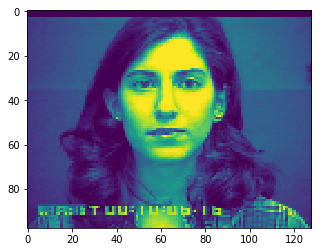

In [18]:
cur_im_idx = 150
cur_im = data['neutral_expression'].loc[cur_im_idx]
plt.imshow(cur_im)

In [98]:
def integral_image(im):
    ii = np.zeros(im.shape)
    
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            ii[x,y] = ii[x,y-1] + sum(im[0:x+1,y])

    return ii

In [99]:
test = np.array([
    [1,2,3],
    [4,5,6],
    [7,8,9]
])
# test
integral_image(test)

array([[ 1.,  3.,  6.],
       [ 5., 12., 21.],
       [12., 27., 45.]])

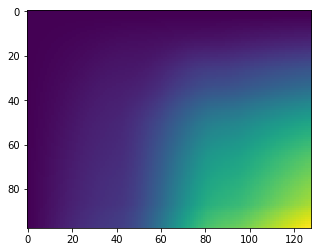

In [125]:
plt.imshow(integral_image(cur_im) / np.max(integral_image(cur_im)))

In [223]:
def naive_two_rect(im, top_left, bottom_right):    
    im_sum = 0
    
    for y in range(top_left[0], bottom_right[0] + 1):
        for x in range(top_left[1], bottom_right[1] + 1):
            im_sum += im[y,x]
            
    return im_sum
    

In [256]:
def ii_two_rect(ii_im, top_left, bottom_right):
    top_right = (top_left[0], bottom_right[1])
    bottom_left =  (bottom_right[0], top_left[1])

    ref1_y, ref1_x = top_left
    ref1_y -= 1
    ref1_x -= 1
    ref1_val = ii_im[ref1_y][ref1_x]
    
    ref2_y, ref2_x = top_right
    ref2_y -= 1
    ref2_val = ii_im[ref2_y][ref2_x]
    
    ref3_y, ref3_x = bottom_left
    ref3_x -= 1    
    ref3_val = ii_im[ref3_y][ref3_x]
    
    br_val = ii_im[bottom_right[0]][bottom_right[1]]

    return br_val + ref1_val - (ref2_val + ref3_val)

#     return ii_im[bottom_right[0]][bottom_right[1]] + ii_im[top_left[0] - 1][top_left[1] - 1] - (
#                             ii_im[top_right[0] - 1][top_right[1]] + ii_im[bottom_left[0]][bottom_left[1] - 1]
#                         )
    

In [234]:
%timeit naive_two_rect(test, (1,1), (2,2))

2.51 µs ± 56.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [255]:
test_ii = integral_image(test)
%timeit ii_two_rect(test_ii, (1,1),(2,2))

2.11 µs ± 17.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [247]:
for im_idx in range(12):
    cur_im = data['neutral_expression'].loc[cur_im_idx]
    cur_ii_im = integral_image(cur_im)
    
    for rect_size in range(2,30):
        print("Computing rectangles of size: ({},{})\n".format(rect_size,rect_size))
        print("Naive timing: ")
        %timeit naive_two_rect(test, (1,1), (2,2))
        
        print("Viola_Jones timing: ")
        %timeit ii_two_rect(test, (1,1), (2,2))
        print("")

Computing rectangles of size: (2,2)

Naive timing: 
2.52 µs ± 21.7 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Viola_Jones timing: 
2.15 µs ± 32.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Computing rectangles of size: (3,3)

Naive timing: 
2.55 µs ± 19.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Viola_Jones timing: 
2.15 µs ± 20.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Computing rectangles of size: (4,4)

Naive timing: 
2.79 µs ± 213 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Viola_Jones timing: 
2.16 µs ± 19.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Computing rectangles of size: (5,5)

Naive timing: 
2.54 µs ± 42.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
Viola_Jones timing: 
2.15 µs ± 9.82 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)

Computing rectangles of size: (6,6)

Naive timing: 
2.52 µs ± 42 ns per loop (mean ± std. dev. of 7 runs,

KeyboardInterrupt: 

(582, 4)